### Author: [Pratik Sharma](https://github.com/sharmapratik88/)
## Import Packages

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, random, csv
import seaborn as sns
from glob import glob
from tqdm import tqdm
%matplotlib inline

# MODEL METRICS
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

# SET VARIABLES
PATH = '/home/pratik_sharma_ds/Capstone_Pneumonia_Detection/'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH + 'data/')
TRAIN_IMAGES = os.path.join(DATA_DIR + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(DATA_DIR + 'stage_2_test_images/')
OUTPUT_DIR = os.path.join(PATH + 'output/')
MODEL_WEIGHTS = os.path.join(PATH + 'model_weights/')
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR + 'stage_2_train_images_png/')
if not os.path.exists(TRAIN_IMAGES_DIR): os.makedirs(TRAIN_IMAGES_DIR)
if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

# CUSTOM MODULE
from module.classify import *

# SET RANDOM SEED
random_state = 2020
random.seed(random_state)
np.random.seed(random_state)

# USE GPU FOR MODEL TRAINING
config = tf.compat.v1.ConfigProto(log_device_placement = True, allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)
list_gpu = tf.config.experimental.list_physical_devices(device_type = 'GPU')
if len(list_gpu)==1: strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else: strategy = tf.distribute.MirroredStrategy()
print('Num GPUs Available: ', len(list_gpu))
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
print('Mixed precision enabled')

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Num GPUs Available:  1
Mixed precision enabled


## Read Data & Prep for Model
* Read a pickle file that was saved as part of [EDA & Data Prep](https://nbviewer.jupyter.org/github/sharmapratik88/Capstone_Pneumonia_Detection/blob/master/Pneumonia_Detection_EDA_%26_Data_Prep.ipynb)

In [3]:
# Read `train_class_features.pkl` file, saved as EDA & Data Prep Module
train_class = pd.read_pickle(OUTPUT_DIR + 'train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,F,32.0,AP


In [4]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))
path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 4)

patientId    26684
path         26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [5]:
# Run only if you haven't converted to png images yet
print('Convert dicom to png images'); print('--'*40)

# image_lists = [f for f in os.listdir(TRAIN_IMAGES)]
# for f in tqdm_notebook(image_lists): 
#     ds = dcm.read_file(TRAIN_IMAGES + f)
#     img = ds.pixel_array
#     cv2.imwrite(TRAIN_IMAGES_DIR + f.replace('.dcm','.png'), img)

Convert dicom to png images
--------------------------------------------------------------------------------


In [6]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)

image_list = list(path_class_target['path'])
random.shuffle(image_list)
val_size = round(len(image_list)/10)
test_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

Split the data in train, valid and test sets
--------------------------------------------------------------------------------


In [7]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(21348, 3)
VALID:(2668, 3)
TEST:(2668, 3)


In [8]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(df_train['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.77
1    0.23
Name: Target, dtype: float64

In [9]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle(OUTPUT_DIR + 'train_data.pkl')
df_valid.to_pickle(OUTPUT_DIR + 'valid_data.pkl')
df_test.to_pickle(OUTPUT_DIR + 'test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


## Model - DenseNet121

In [10]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_densenet.h5'
FINAL_MODEL = 'best_densenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', average_precision, f1_score]

In [11]:
df_train['Target'] = df_train['Target'].astype(str); 
df_valid['Target'] = df_valid['Target'].astype(str); 
df_test['Target'] = df_test['Target'].astype(str)

In [12]:
print('Create generators for training, validation and test dataframes'); print('--'*40)
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = BATCH_SIZE, 
                            path = TRAIN_IMAGES_DIR, 
                            img_size = (IMAGE_SIZE, IMAGE_SIZE), 
                            class_mode = 'binary',
                            random_state = random_state)

Create generators for training, validation and test dataframes
--------------------------------------------------------------------------------
Train Generator Created ----------------------------------------
Found 21348 validated image filenames belonging to 2 classes.
Validation Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.
Test Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.


In [13]:
def build_model():
    print('Create a `DenseNet121` model'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'DenseNet121')
    
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    
    callbacks = [cp, csv_logger, lrscheduler]
    return callbacks

In [14]:
print('Lets fit the model.....')
K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks = callbacks()
    train_generator = generators.train_generator
    validation_generator = generators.valid_generator
    test_generator = generators.test_generator    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = generators.step_size_train,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks,
                                  validation_data = validation_generator, 
                                  validation_steps = generators.step_size_valid)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `DenseNet121` model
--------------------------------------------------------------------------------
Model: "DenseNet121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DenseNet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
Train for 668 steps, validate for 84 steps
Epoch 1/10
667/668 [============================>.] - ETA: 0s

In [15]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [16]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy, ap, f1 = model.evaluate_generator(generator = validation_generator, 
                                          steps = generators.step_size_valid)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}, AP: {round(float(ap), 3)}, F1 Score: {round(float(f1), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.336, Accuracy: 0.845, AP: 0.701, F1 Score: 0.6


In [17]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         steps = generators.step_size_valid,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
84/84 [==============================] - 26s 313ms/step


In [18]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                                        steps = generators.step_size_test,
                                        verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

Predict on the test data
--------------------------------------------------------------------------------
84/84 [==============================] - 26s 315ms/step


In [19]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2071
1     597
dtype: int64

0    2042
1     626
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.890


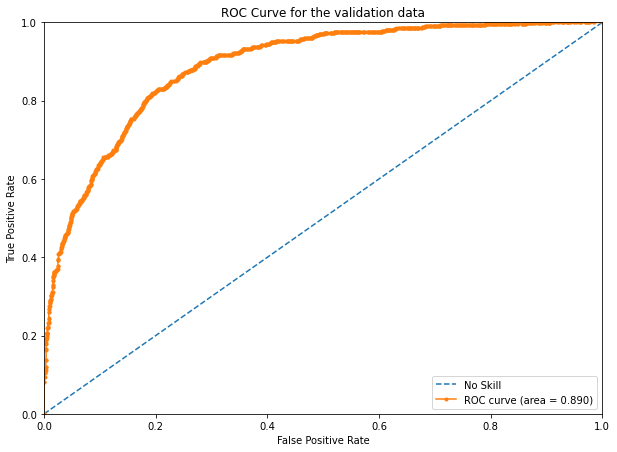

In [20]:
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.894


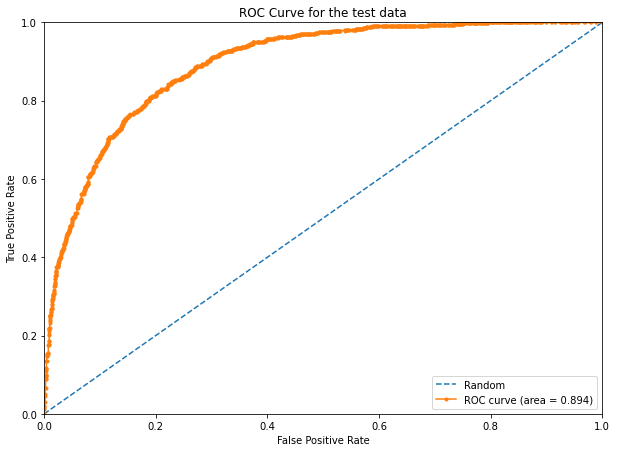

In [21]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


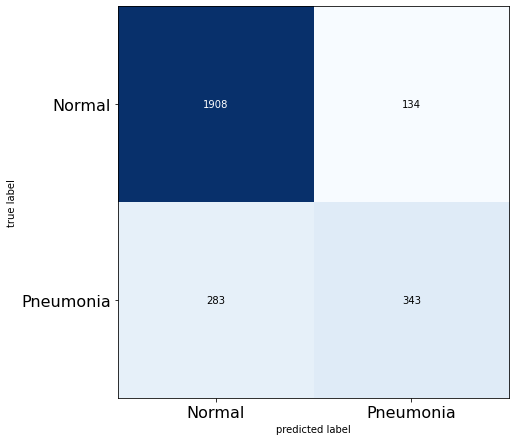

In [22]:
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [23]:
print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.87      0.93      0.90      2042
   Pneumonia       0.72      0.55      0.62       626

    accuracy                           0.84      2668
   macro avg       0.79      0.74      0.76      2668
weighted avg       0.84      0.84      0.84      2668



## Model - DenseNet121 + CheXNet pre-trained weights
Acknowledgement for the pre-trained weights:
We used pre-trained weights available from the following [repository](https://github.com/brucechou1983/CheXNet-Keras).

In [24]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 10
LEARNING_RATE = 1e-3
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_chexnet.h5'
FINAL_MODEL = 'best_chexnet_final.h5'
LOG_FILE = 'logs_chexnet.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', average_precision, f1_score]

In [25]:
print('Create generators for training, validation and test dataframes'); print('--'*40)
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = BATCH_SIZE, 
                            path = TRAIN_IMAGES_DIR, 
                            img_size = (IMAGE_SIZE, IMAGE_SIZE), 
                            class_mode = 'binary',
                            random_state = random_state)

Create generators for training, validation and test dataframes
--------------------------------------------------------------------------------
Train Generator Created ----------------------------------------
Found 21348 validated image filenames belonging to 2 classes.
Validation Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.
Test Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.


In [26]:
def build_model():
    print('Create a `CheXNet-like` model using pre-trained weights'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = True, input_tensor = inputs, weights = MODEL_WEIGHTS + 'CheXNet weights.h5', classes = 14)
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-2].output, name = 'CheXNet-like')
    
    model = Sequential(name = 'CheXNet-like')
    model.add(densenet)
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    
    callbacks = [cp, csv_logger, lrscheduler]
    return callbacks

In [27]:
print('Lets fit the model.....')
K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks = callbacks()
    train_generator = generators.train_generator
    validation_generator = generators.valid_generator
    test_generator = generators.test_generator    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = generators.step_size_train,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks,
                                  validation_data = validation_generator, 
                                  validation_steps = generators.step_size_valid)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `CheXNet-like` model using pre-trained weights
--------------------------------------------------------------------------------
Model: "CheXNet-like"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CheXNet-like (Model)         (None, 1024)              7037504   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
Train for 668 steps, validate for 84 steps
Epoch 1/10
667/668 [============================>.] - ETA: 0s - loss: 0.3733 - accuracy: 0.8300 - average_precision: 0.6600 - f1_score: 0.5311
Epoch 00001: val_loss 

In [28]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [29]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy, ap, f1 = model.evaluate_generator(generator = validation_generator, 
                                          steps = generators.step_size_valid)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}, AP: {round(float(ap), 3)}, F1 Score: {round(float(f1), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.325, Accuracy: 0.848, AP: 0.692, F1 Score: 0.61


In [30]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         steps = generators.step_size_valid,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
84/84 [==============================] - 26s 314ms/step


In [31]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                                        steps = generators.step_size_test,
                                        verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

Predict on the test data
--------------------------------------------------------------------------------
84/84 [==============================] - 26s 311ms/step


In [32]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2071
1     597
dtype: int64

0    2042
1     626
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.898


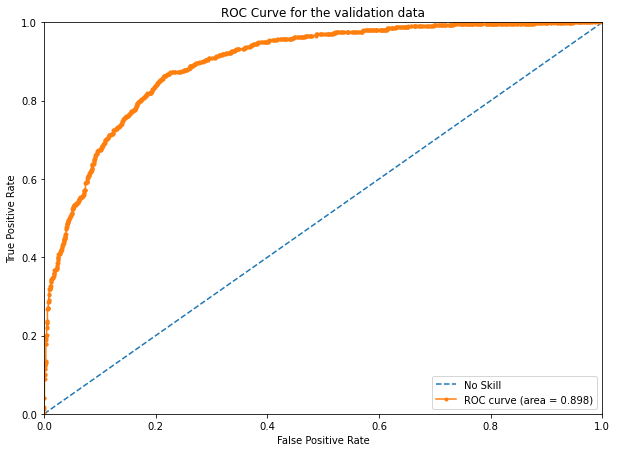

In [33]:
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.895


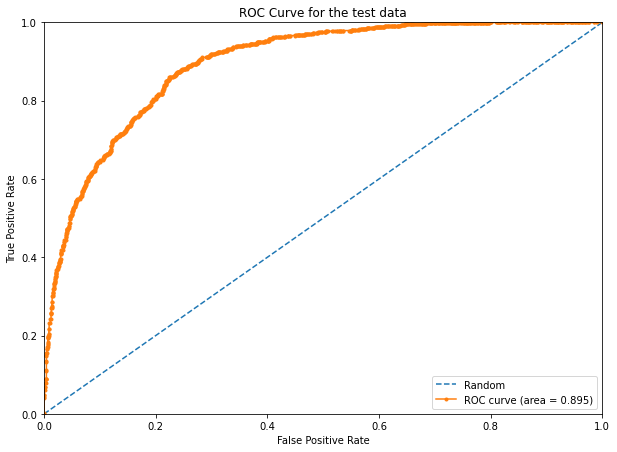

In [34]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


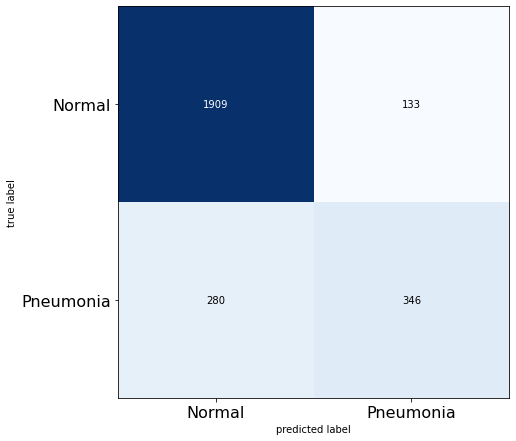

In [35]:
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [36]:
print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.87      0.93      0.90      2042
   Pneumonia       0.72      0.55      0.63       626

    accuracy                           0.85      2668
   macro avg       0.80      0.74      0.76      2668
weighted avg       0.84      0.85      0.84      2668



Train/Validation Accuracy/Loss Comparison
--------------------------------------------------------------------------------


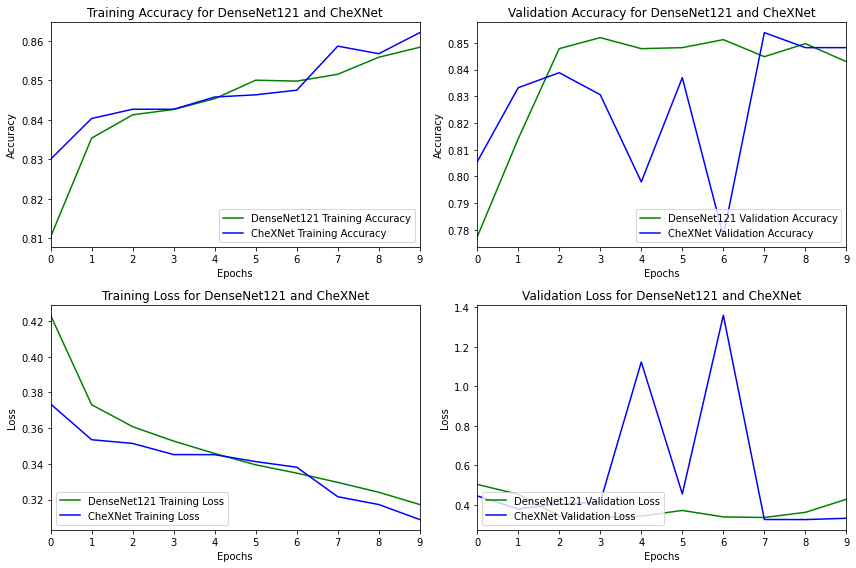

In [37]:
print('Train/Validation Accuracy/Loss Comparison'); print('--'*40)
logs = pd.read_csv(MODEL_WEIGHTS + 'logs.csv')
logs_chex = pd.read_csv(MODEL_WEIGHTS + 'logs_chexnet.csv')
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8))

ax1.plot(logs['epoch'], logs['accuracy'], 'g', label = 'DenseNet121 Training Accuracy')
ax1.plot(logs_chex['epoch'], logs_chex['accuracy'], 'b', label = 'CheXNet Training Accuracy')
ax1.set_title('Training Accuracy for DenseNet121 and CheXNet')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(0, logs['epoch'].max())
# ax1.set_ylim(0, 1)
ax1.legend(loc = 'lower right')

ax2.plot(logs['epoch'], logs['val_accuracy'], 'g', label = 'DenseNet121 Validation Accuracy')
ax2.plot(logs_chex['epoch'], logs_chex['val_accuracy'], 'b', label = 'CheXNet Validation Accuracy')
ax2.set_title('Validation Accuracy for DenseNet121 and CheXNet')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, logs['epoch'].max())
# ax2.set_ylim(0, 1)
ax2.legend(loc = 'lower right')

ax3.plot(logs['epoch'], logs['loss'], 'g', label = 'DenseNet121 Training Loss')
ax3.plot(logs_chex['epoch'], logs_chex['loss'], 'b', label = 'CheXNet Training Loss')
ax3.set_title('Training Loss for DenseNet121 and CheXNet')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_xlim(0, logs['epoch'].max())
# ax3.set_ylim(0, logs['loss'].max())
ax3.legend(loc = 'lower left')

ax4.plot(logs['epoch'], logs['val_loss'], 'g', label = 'DenseNet121 Validation Loss')
ax4.plot(logs_chex['epoch'], logs_chex['val_loss'], 'b', label = 'CheXNet Validation Loss')
ax4.set_title('Validation Loss for DenseNet121 and CheXNet')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')
ax4.set_xlim(0, logs['epoch'].max())
# ax4.set_ylim(0, logs['val_loss'].max())
ax4.legend(loc = 'lower left')
plt.tight_layout()
plt.show()